# CpE Elective 2 Laboratory (LBYCPH3) <br/>
#### Computer Vision and Deep Learning Elective Track
<br/>
<hr style="border:5px solid gray">


In [1]:
# Import libraries
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras_cv
import pandas as pd

2024-03-31 14:08:21.540919: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 14:08:21.541002: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 14:08:21.541033: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-31 14:08:21.551538: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 14:08:22.544361: W tensorflow/compiler/

Using TensorFlow backend


In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="eOlHh5ddJ8DYoXsK7Tnw")
project = rf.workspace("renz").project("lthr-dtctrn2")
version = project.version(12)
dataset = version.download("retinanet")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
HOME = os.getcwd()
print(HOME)

Num GPUs Available:  1
/home/evaristo/LBYCPH3_Project_1


2024-03-31 14:08:27.291719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 14:08:27.355419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 14:08:27.355609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
# Define class names
class_names = {0: 'cut', 1: 'fold', 2: 'stain'}

# Define paths to train, test, and validation folders
train_folder = str(HOME) + '/Lthr-Dtctrn2-12/train'
test_folder = str(HOME) + '/Lthr-Dtctrn2-12/test'
valid_folder = str(HOME) + '/Lthr-Dtctrn2-12/valid'

column_names = ['filename', 'x_min', 'y_min', 'x_max', 'y_max', 'class']

def load_ds(dir_path, cn=class_names, bounding_box_format="xyxy"):
    annotations_df = pd.read_csv(os.path.join(dir_path, '_annotations.csv'), header=None, names=column_names)

    outer_box, outer_class = list(), list()
    inner_box, inner_class = list(), list()
    previous_file = ""
    img_files = []

    for index, item in annotations_df.iterrows():
      current_file = item['filename']
      if current_file != previous_file:
        img_files.append(os.path.join(dir_path, current_file))
        if inner_box:
            outer_box.append(inner_box)
            outer_class.append(inner_class)
        inner_box = []
        inner_class = []
        previous_file = current_file

      box = item[['x_min', 'y_min', 'x_max', 'y_max']].values.tolist()
      cls = list(cn.keys())[list(cn.values()).index(item['class'])]
      inner_box.append(box)
      inner_class.append(cls)

    if inner_box:
        outer_box.append(inner_box)
        outer_class.append(inner_class)

    outer_box = tf.ragged.constant(outer_box)
    outer_class = tf.ragged.constant(outer_class)
    image_paths = tf.ragged.constant(img_files)

    return tf.data.Dataset.from_tensor_slices((image_paths, outer_class, outer_box))

def preprocess_ds(image_path, classes, bbox):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  bounding_boxes = {
    "classes": tf.cast(classes, dtype=tf.float32),
    "boxes": bbox,
  }
  return {"images": tf.cast(image, tf.float32),
          "bounding_boxes": bounding_boxes}

train_dataset = load_ds(train_folder).map(preprocess_ds)
test_dataset = load_ds(test_folder).map(preprocess_ds)
valid_dataset = load_ds(valid_folder).map(preprocess_ds)

2024-03-31 14:08:28.154233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 14:08:28.154416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 14:08:28.154506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 14:08:28.356220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-31 14:08:28.356430: I tensorflow/compile

<class 'tensorflow.python.ops.ragged.ragged_tensor.RaggedTensor'>
<class 'dict'>


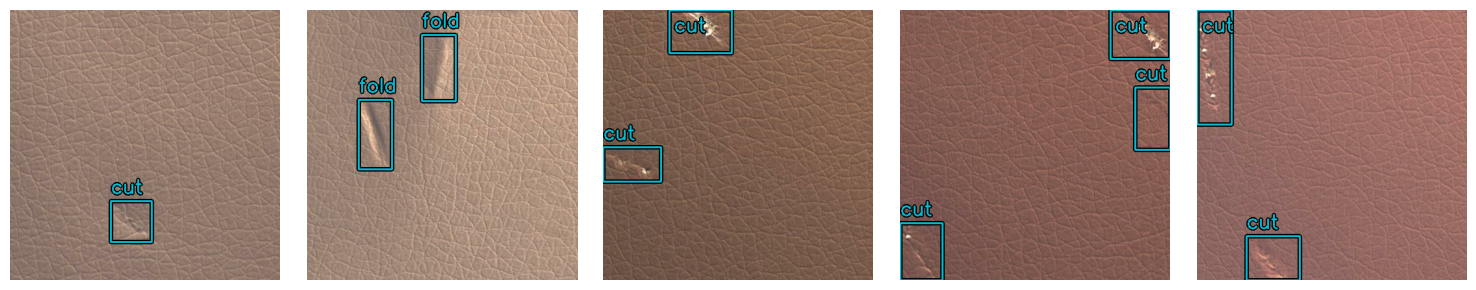

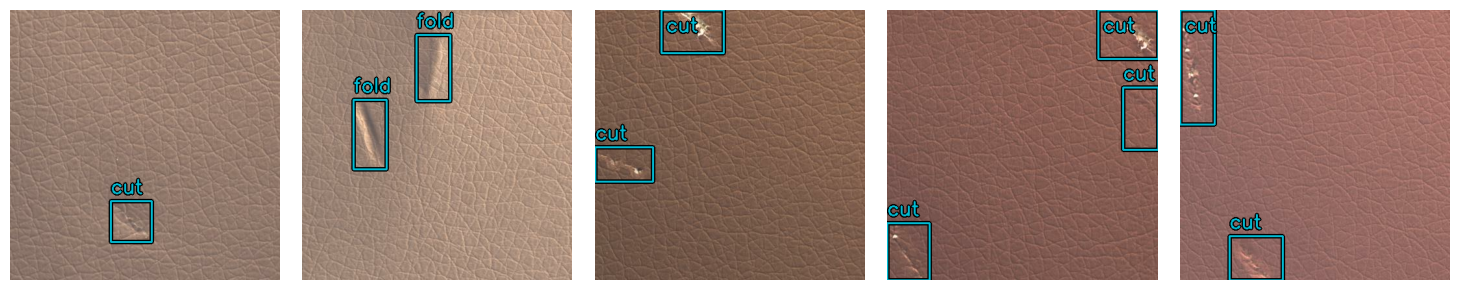

In [5]:
from keras_cv.visualization import plot_bounding_box_gallery

# Take 10 samples from the train dataset
train_dataset_sample = next(iter(train_dataset.take(10).ragged_batch(10)))

# Extract the image and bounding box
train_dataset_sample_images = train_dataset_sample["images"]
train_dataset_sample_bboxs = train_dataset_sample["bounding_boxes"]

print(type(train_dataset_sample_images))
print(type(train_dataset_sample_bboxs))
# Visualize the ground truth bounding boxes
plot_bounding_box_gallery(train_dataset_sample_images,
                          value_range=(0, 255),
                          rows=1, cols=5,
                          y_true=train_dataset_sample_bboxs,
                          scale=3,
                          font_scale=1,
                          bounding_box_format="xyxy",
                          class_mapping=class_names)

In [6]:
# Import Keras Sequential class
from keras import Sequential

# Import Keras CV classes and functions for dataset augmentation
from keras_cv.layers import RandomFlip, JitteredResize, Resizing

augmenter_fn = Sequential(
    layers=[
        RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        JitteredResize(target_size=(640, 640),
                       scale_factor=(0.75, 1.25),
                       bounding_box_format="xyxy")]
)

resizer_fn = Resizing(416, 416, pad_to_aspect_ratio=True, bounding_box_format="XYXY")
train_dataset = train_dataset.map(resizer_fn)
valid_dataset = valid_dataset.map(resizer_fn)

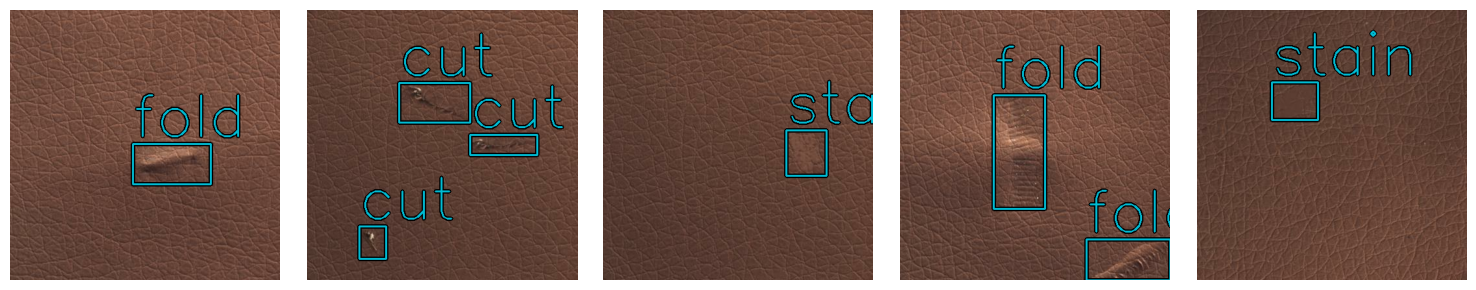

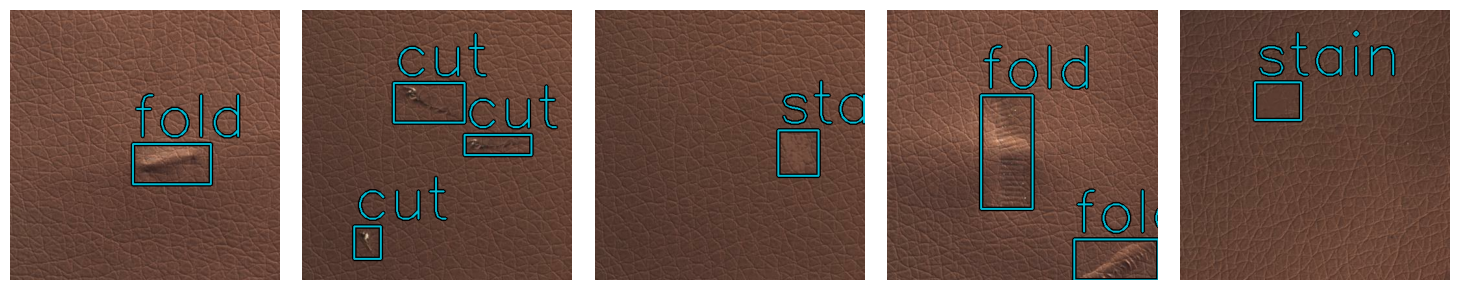

In [7]:
# Visualize some samples of augmented train dataset

# Take 10 samples from the augmented train dataset
valid_dataset_sample = next(iter(valid_dataset.take(10).ragged_batch(10)))

# Extract the image and bounding box
valid_dataset_sample_images = valid_dataset_sample["images"]
valid_dataset_sample_bboxs = valid_dataset_sample["bounding_boxes"]

plot_bounding_box_gallery(
        valid_dataset_sample_images,
        value_range=(0, 255),
        rows=1,
        cols=5,
        y_true=valid_dataset_sample_bboxs,
        scale=3,
        font_scale=3,
        bounding_box_format="XYXY",
        class_mapping=class_names,
    )

In [8]:
from keras_cv.models import RetinaNet

objdet_model = RetinaNet.from_preset(
    "yolo_v8_l_backbone_coco",num_classes=3,
    bounding_box_format="XYXY",)

from keras.utils import plot_model
plot_model(objdet_model, show_shapes=True, show_layer_names=True,   show_layer_activations=True)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2024-03-31 14:08:39.426455: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [9]:
objdet_model.get_layer("model").trainable = False
from keras.optimizers import Adam

optim_adam = Adam(
    learning_rate=0.001,
    global_clipnorm=10
)

objdet_model.compile(
    optimizer=optim_adam,
    classification_loss='focal',
    box_loss='smoothL1'
)
objdet_model.summary()

Model: "retina_net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 images (InputLayer)         [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    1983174   ['images[0][0]']              
                             256),                        4                                       
                              'P4': (None, None, None,                                            
                             512),                                                                
                              'P5': (None, None, None,                                            
                             512)}                                                       

In [10]:
# Preprocess train and validation datasets prior to training
def dict_to_tuple(inputs):
  return inputs["images"], inputs["bounding_boxes"]
train_dataset = train_dataset.map(dict_to_tuple).ragged_batch(10)
valid_dataset = valid_dataset.map(dict_to_tuple).ragged_batch(10)

hist = objdet_model.fit(train_dataset, epochs=20, validation_data=valid_dataset)

Epoch 1/20


2024-03-31 14:08:55.412294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-03-31 14:08:55.612291: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-31 14:08:58.948673: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-31 14:09:20.439722: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fcdbbd28ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-31 14:09:20.439799: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-03-31 14:09:20.455545: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util

107/107 [==============================] - 246s 2s/step - loss: 2.9581 - box_loss: 0.5694 - classification_loss: 2.3887 - percent_boxes_matched_with_anchor: 0.3783 - val_loss: 0.8967 - val_box_loss: 0.4374 - val_classification_loss: 0.4593 - val_percent_boxes_matched_with_anchor: 0.3820
Epoch 2/20
107/107 [==============================] - 180s 2s/step - loss: 0.7397 - box_loss: 0.3667 - classification_loss: 0.3730 - percent_boxes_matched_with_anchor: 0.3783 - val_loss: 0.6942 - val_box_loss: 0.3642 - val_classification_loss: 0.3301 - val_percent_boxes_matched_with_anchor: 0.3820
Epoch 3/20
107/107 [==============================] - 180s 2s/step - loss: 0.5636 - box_loss: 0.2919 - classification_loss: 0.2717 - percent_boxes_matched_with_anchor: 0.3783 - val_loss: 0.6204 - val_box_loss: 0.2982 - val_classification_loss: 0.3222 - val_percent_boxes_matched_with_anchor: 0.3820
Epoch 4/20
107/107 [==============================] - 180s 2s/step - loss: 0.4564 - box_loss: 0.2436 - classificat

In [11]:
# Save model
objdet_model.save('retinanet_yolov8_large_leatherds_model.keras')

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
`layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


dict_keys(['loss', 'box_loss', 'classification_loss', 'percent_boxes_matched_with_anchor', 'val_loss', 'val_box_loss', 'val_classification_loss', 'val_percent_boxes_matched_with_anchor'])


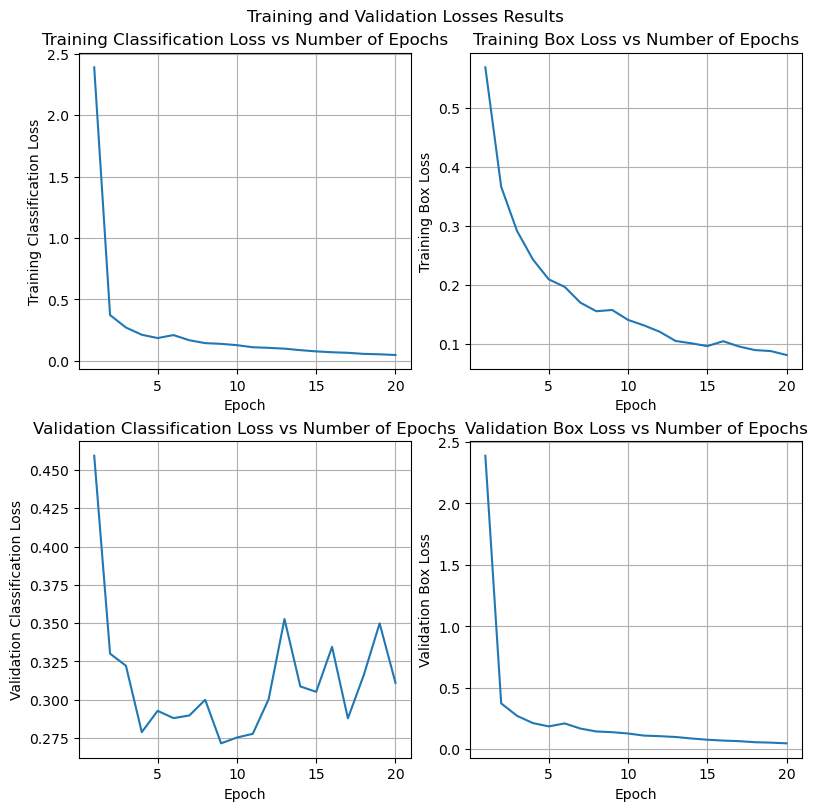

In [12]:
# Extract model training and validation losses during training
# Figure out the available keys on the hist variable
print(hist.history.keys())
training_box_losses = hist.history["box_loss"]
training_classification_losses = hist.history["classification_loss"]
validation_box_losses = hist.history["val_box_loss"]
validation_classification_losses = hist.history["val_classification_loss"]

epochs = range(1, len(training_box_losses) + 1)

# Plot the history of training and validation losses
fig = plt.figure(figsize=(8,8), constrained_layout=True)
plt.suptitle('Training and Validation Losses Results')
plt.subplot(2,2,1)
plt.title("Training Classification Loss vs Number of Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Classification Loss")
plt.grid()
plt.plot(epochs, training_classification_losses)

plt.subplot(2,2,2)
plt.title("Training Box Loss vs Number of Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Box Loss")
plt.grid()
plt.plot(epochs, training_box_losses)

plt.subplot(2,2,3)
plt.title("Validation Classification Loss vs Number of Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Classification Loss")
plt.grid()
plt.plot(epochs, validation_classification_losses)

plt.subplot(2,2,4)
plt.title("Validation Box Loss vs Number of Epochs")
plt.xlabel("Epoch")
plt.ylabel("Validation Box Loss")
plt.grid()
plt.plot(epochs, training_classification_losses)

plt.show()

In [13]:
# Initialize count for true positives, false positives, false negatives
TP, FP, FN = 0, 0, 0

# Iterate through all IoUs and check the number of
# true positives and false positives
for apple_iou, banana_iou, orange_iou in zip(apple_ious, banana_ious, orange_ious):
    try:
        if apple_iou[0] is not None and apple_iou[0] >= 0.5:
            # Increment TP
            TP += 1
        else:
            # Increment FP
            FP += 1
    except:
        FP += 1

# Compute the precision
# Result should be saved to precision variable
precision = TP / (TP + FP)

# Compute the recall
# Result should be saved to recall variable
if TP + FN != 0:
    recall = TP / (TP + FN)
else:
    recall = 0.0

# Display the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


NameError: name 'apple_ious' is not defined

### References

[1] C. Aggarwal. *Neural Networks and Deep Learning : A Textbook*. 2nd ed. Cham: Springer International Publishing, 2023.

[2] I. Goodfellow, Y. Bengio and A. Courville, *Deep Learning*. MIT Press, 2016.

[3] *Keras 3 API documentation*. https://keras.io/api/

[4] *Keras CV API documentation*. https://keras.io/keras_cv/